# BinWaves example in Cantabria

In [1]:
import os

import numpy as np
import wavespectra
import xarray as xr
from wavespectra.construct import construct_partition

from bluemath_tk.core.operations import convert_utm_to_lonlat
from bluemath_tk.waves.binwaves import (
    generate_swan_cases,
    process_kp_coefficients,
    reconstruc_spectra,
    plot_selected_cases_grid,
)
from bluemath_tk.wrappers.swan.swan_wrapper import SwanModelWrapper

from utils.plotting import (
    plot_bathymetry,
    plot_cases_grid,
    plot_case_variables,
    plot_wave_series,
)
from utils.operations import transform_CAWCR_WS

## Plot basic data

In [2]:
bathy = xr.open_dataset(
    "http://geoocean.sci.unican.es/thredds/dodsC/geoceanWork/users/Gabriel/Binwaves/binwaves/data/bathymetry/bati_cantabria_100m.nc"
)
bathy["cx"], bathy["cy"] = convert_utm_to_lonlat(
    bathy.cx.values, bathy.cy.values, "SPAIN"
)
bathy

<xarray.Dataset> Size: 3MB
Dimensions:    (cx: 821, cy: 451)
Coordinates:
  * cx         (cx) float64 7kB -4.182 -4.181 -4.18 ... -3.173 -3.172 -3.17
  * cy         (cy) float64 4kB 43.36 43.36 43.36 43.36 ... 43.76 43.76 43.76
Data variables:
    elevation  (cx, cy) float64 3MB ...

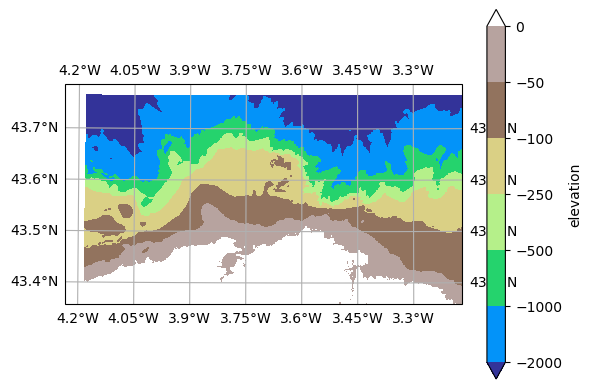

In [3]:
plot_bathymetry(data=bathy.elevation.T, cmap="terrain")

## Create SWAN Wrapper

In [4]:
example_directions = [
    262.5,
    247.5,
    232.5,
    217.5,
    202.5,
    187.5,
    172.5,
    157.5,
    142.5,
    127.5,
    112.5,
    97.5,
    82.5,
    67.5,
    52.5,
    37.5,
    22.5,
    7.5,
    352.5,
    337.5,
    322.5,
    307.5,
    292.5,
    277.5,
]
example_frequencies = [
    0.03500004,
    0.03850004,
    0.04234991,
    0.04658508,
    0.05124342,
    0.05636788,
    0.06200474,
    0.06820491,
    0.07502551,
    0.082528,
    0.09078117,
    0.0998592,
    0.10984545,
    0.12082986,
    0.13291333,
    0.14620311,
    0.16082342,
    0.17690661,
    0.19459796,
    0.21405484,
    0.23546032,
    0.25900697,
    0.2849084,
    0.31340103,
    0.34474437,
    0.37921881,
    0.41713594,
    0.45884188,
    0.5047446,
]


class BinWavesWrapper(SwanModelWrapper):
    """
    Wrapper example for the BinWaves model.
    """

    def build_case(self, case_dir: str, case_context: dict):
        input_spectrum = construct_partition(
            freq_name="jonswap",
            freq_kwargs={
                "freq": example_frequencies,
                "fp": 1.0 / case_context.get("tp"),
                "hs": case_context.get("hs"),
            },
            dir_name="cartwright",
            dir_kwargs={
                "dir": example_directions,
                "dm": case_context.get("dir"),
                "dspr": case_context.get("spr"),
            },
        )
        argmax_bin = np.argmax(input_spectrum.values)
        mono_spec_array = np.zeros(input_spectrum.freq.size * input_spectrum.dir.size)
        mono_spec_array[argmax_bin] = input_spectrum.sum(dim=["freq", "dir"])
        mono_spec_array = mono_spec_array.reshape(
            input_spectrum.freq.size, input_spectrum.dir.size
        )
        mono_input_spectrum = xr.Dataset(
            {
                "efth": (["freq", "dir"], mono_spec_array),
            },
            coords={
                "freq": input_spectrum.freq,
                "dir": input_spectrum.dir,
            },
        )
        wavespectra.SpecDataset(mono_input_spectrum).to_swan(
            os.path.join(case_dir, "input_spectra.bnd")
        )

    def build_cases(self, mode="one_by_one"):
        super().build_cases(mode)
        for case_dir, case_context in zip(self.cases_dirs, self.cases_context):
            self.build_case(case_dir, case_context)

In [5]:
# Define the input templates and output directory for the wrapper

templates_dir = os.path.join(os.getcwd(), "templates")
templates_name = ["input.swn", "depth.dat", "buoys.loc"]
output_dir = os.path.join(os.getcwd(), "CAN_cases")

In [6]:
# Generate swan model parameters

swan_cases_df = (
    generate_swan_cases(
        directions_array=example_directions,
        frequencies_array=example_frequencies,
    )
    .astype(float)
    .to_dataframe()
    .reset_index()
)
model_parameters = swan_cases_df.to_dict(orient="list")

swan_cases_df

,dir,freq,hs,tp,spr,gamma
0,262.5,0.035000,1.0,28.5714,2.0,50.0
1,262.5,0.038500,1.0,25.9740,2.0,50.0
2,262.5,0.042350,1.0,23.6128,2.0,50.0
3,262.5,0.046585,1.0,21.4661,2.0,50.0
4,262.5,0.051243,1.0,19.5147,2.0,50.0
...,...,...,...,...,...,...
691,277.5,0.344744,0.1,2.9007,2.0,50.0
692,277.5,0.379219,0.1,2.6370,2.0,50.0
693,277.5,0.417136,0.1,2.3973,2.0,50.0
694,277.5,0.458842,0.1,2.1794,2.0,50.0


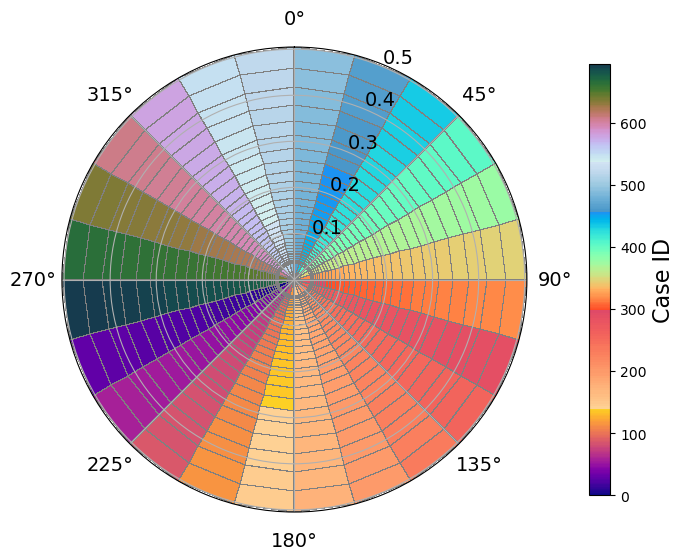

In [10]:
plot_selected_cases_grid(
    frequencies=np.array(example_frequencies),
    directions=np.array(example_directions),
    figsize=(8, 8),
)

In [11]:
# Create an instance of the SWAN model wrapper

swan_wrapper = BinWavesWrapper(
    templates_dir=templates_dir,
    templates_name=templates_name,
    model_parameters=model_parameters,
    output_dir=output_dir,
)

2025-03-05 15:47:38,807 - BinWavesWrapper - WARNING - Setting self.num_workers to 1. 
Change it using self.set_num_processors_to_use method.
2025-03-05 15:47:38,808 - BinWavesWrapper - INFO - Parameter dir has the correct type: <class 'float'>
2025-03-05 15:47:38,808 - BinWavesWrapper - WARNING - Parameter freq is not in the default_parameters
2025-03-05 15:47:38,809 - BinWavesWrapper - INFO - Parameter hs has the correct type: <class 'float'>
2025-03-05 15:47:38,809 - BinWavesWrapper - INFO - Parameter tp has the correct type: <class 'float'>
2025-03-05 15:47:38,809 - BinWavesWrapper - INFO - Parameter spr has the correct type: <class 'float'>
2025-03-05 15:47:38,810 - BinWavesWrapper - WARNING - Parameter gamma is not in the default_parameters


In [12]:
# Build the input files

# swan_wrapper.build_cases(mode="one_by_one")

# Set the cases directories from the output directory
# Execute if the cases are already built

swan_wrapper.set_cases_dirs_from_output_dir()

2025-03-05 15:47:39,355 - BinWavesWrapper - INFO - Cases directories set from /home/tausiaj/GitHub-GeoOcean/BlueMath_notebooks/hybrid_downscaling/additive/BinWaves/CAN_cases.


In [13]:
# List available launchers

swan_wrapper.list_available_launchers()

{'bash': 'swanrun -input input',
 'docker': 'docker run --rm -v .:/case_dir -w /case_dir tausiaj/swan-geoocean:41.51 swanrun -input input',
 'docker_serial': 'docker run --rm -v .:/case_dir -w /case_dir geoocean/rocky8 swash_serial.exe'}

In [14]:
# Run the model

# swan_wrapper.run_cases_in_background(launcher="docker", num_workers=5)

In [15]:
# Post-process the output files

# cases_bulk_parameters = swan_wrapper.postprocess_cases(num_workers=5, write_output_nc=False)
# cases_bulk_parameters["Xp"], cases_bulk_parameters["Yp"] = convert_utm_to_lonlat(
#     cases_bulk_parameters.Xp.values, cases_bulk_parameters.Yp.values, "SPAIN"
# )
# cases_bulk_parameters.to_netcdf("outputs/cases_bulk_parameters.nc")

cases_bulk_parameters = xr.open_dataset("outputs/cases_bulk_parameters.nc")
cases_bulk_parameters["Xp"], cases_bulk_parameters["Yp"] = convert_utm_to_lonlat(
    cases_bulk_parameters.Xp.values, cases_bulk_parameters.Yp.values, "SPAIN"
)
cases_bulk_parameters

<xarray.Dataset> Size: 2GB
Dimensions:   (case_num: 692, Yp: 355, Xp: 699)
Coordinates:
  * Xp        (Xp) float64 6kB -4.111 -4.11 -4.108 ... -3.249 -3.248 -3.247
  * Yp        (Yp) float64 3kB 43.37 43.37 43.37 43.37 ... 43.69 43.69 43.69
  * case_num  (case_num) int64 6kB 0 2 5 6 8 9 10 ... 690 691 692 693 694 695
Data variables:
    Hsig      (case_num, Yp, Xp) float32 687MB ...
    Tm02      (case_num, Yp, Xp) float32 687MB ...
    Dir       (case_num, Yp, Xp) float32 687MB ...

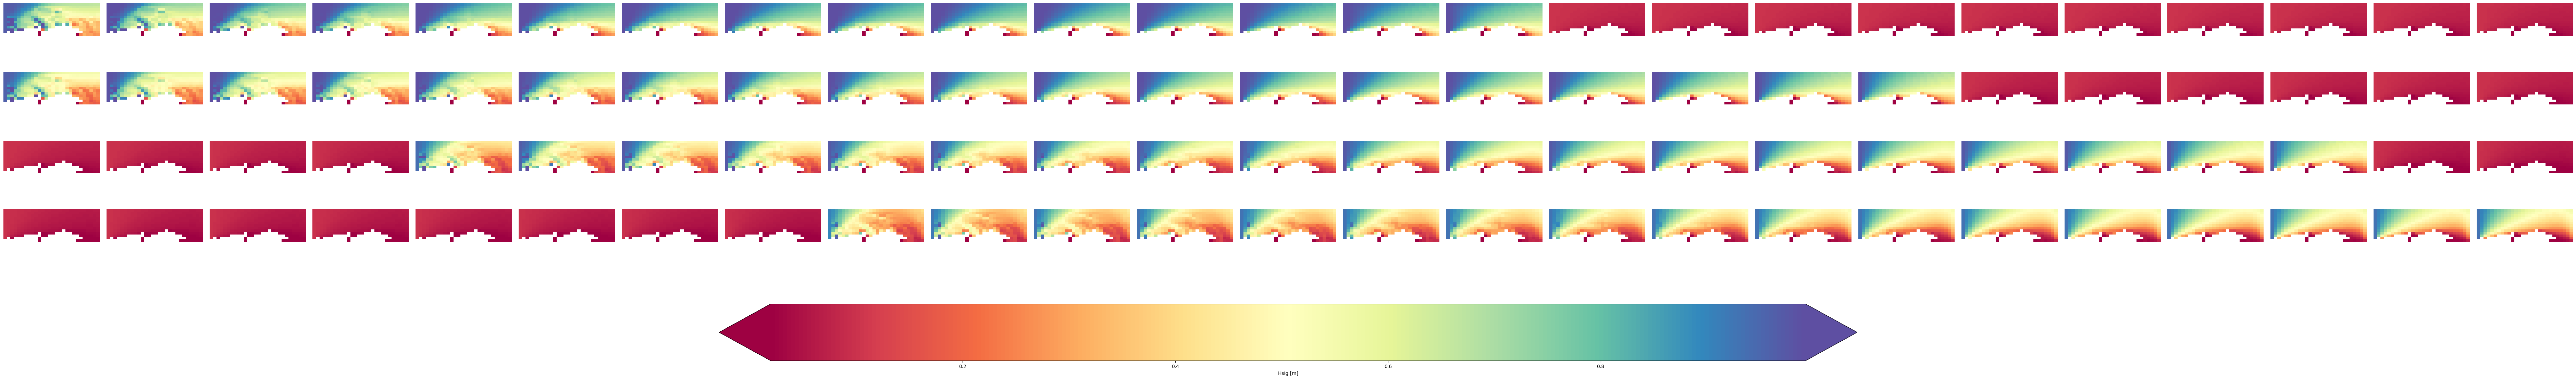

In [23]:
import matplotlib.pyplot as plt

plot_cases_grid(
    data=cases_bulk_parameters.Hsig.isel(
        Xp=slice(None, None, 25),
        Yp=slice(None, None, 25),
        case_num=slice(0, 100),
    ),
    cmap="Spectral",
    cbar_kwargs={
        "label": "Hsig [m]",
        "orientation": "horizontal",
    },
    robust=True,
)

/home/tausiaj/miniforge3/envs/bluemath-dev/lib/python3.12/site-packages/matplotlib/colors.py:2293: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


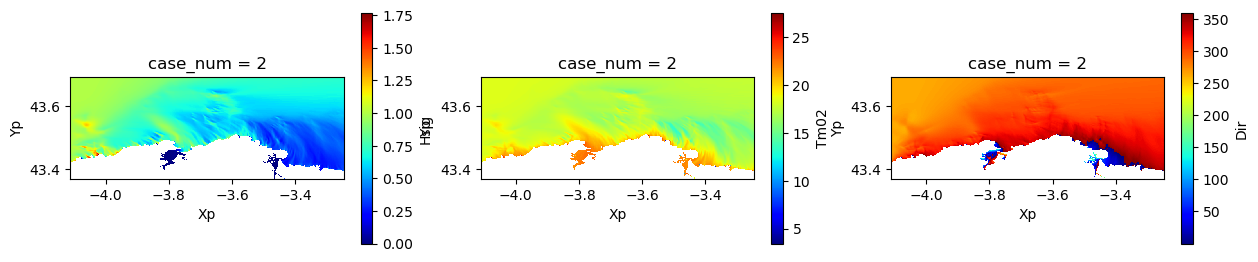

In [24]:
plot_case_variables(
    data=cases_bulk_parameters.isel(case_num=1),
    cmap="jet",
)

In [25]:
# Get input and output spectra files from self.cases_dirs

input_files = [os.path.join(d, "input_spectra.bnd") for d in swan_wrapper.cases_dirs]
output_files = [os.path.join(d, "output.spec") for d in swan_wrapper.cases_dirs]

# Extract binwaves kp coeffs

# kp_coeffs = process_kp_coefficients(
#     list_of_input_spectra=input_files,
#     list_of_output_spectra=output_files,
# )
# kp_coeffs.to_netcdf("outputs/kp_coeffs.nc")

kp_coeffs = xr.open_dataset("outputs/kp_coeffs.nc")
kp_coeffs

<xarray.Dataset> Size: 606MB
Dimensions:   (case_num: 692, site: 24, freq: 38, dir: 120)
Coordinates:
  * case_num  (case_num) int64 6kB 0 2 5 6 8 9 10 ... 690 691 692 693 694 695
  * site      (site) int64 192B 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
  * freq      (freq) float64 304B 0.03 0.033 0.0363 0.0399 ... 0.8273 0.9096 1.0
  * dir       (dir) float64 960B 1.5 4.5 7.5 10.5 ... 349.5 352.5 355.5 358.5
    time      datetime64[ns] 8B ...
    lat       float64 8B ...
    lon       float64 8B ...
Data variables:
    efth      (case_num, site, freq, dir) float64 606MB ...

In [31]:
# Load interest spectra

_, offshore_spectra = transform_CAWCR_WS(
    cawcr_dataset=xr.open_dataset(
        "/home/tausiaj/GitHub-GeoOcean/BlueMath/test_data/ERA5_full.nc"
    ),
    subset_parameters=model_parameters,
    available_case_num=kp_coeffs.case_num.values,
)
offshore_spectra

<xarray.DataArray 'efth' (case_num: 692, time: 17520)> Size: 97MB
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.46727731e-06, 2.74353282e-06, 0.00000000e+00, ...,
        2.51669694e-04, 3.10641143e-04, 3.62449514e-04],
       [1.91092512e-03, 1.89029968e-03, 1.94021481e-03, ...,
        5.75008078e-03, 6.67565053e-03, 7.74921899e-03],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * case_num   (case_num) int64 6kB 0 2 5 6 8 9 10 ... 690 691 692 693 694 695
    longitude  float32 4B 356.1
    latitude   float32 4B 43.82
  * time       (time) datetime64[ns] 140kB 2009-01-01 ... 2010-12-31T23:00:00

In [2]:
# Reconstruct spectra

# reconstructed_onshore_spectra = reconstruc_spectra(
#     offshore_spectra=offshore_spectra,
#     kp_coeffs=kp_coeffs,
# )
# reconstructed_onshore_spectra.to_netcdf("outputs/reconstructed_onshore_spectra.nc")

reconstructed_onshore_spectra = xr.open_dataset(
    "outputs/reconstructed_onshore_spectra.nc"
)
reconstructed_onshore_spectra

<xarray.Dataset> Size: 15GB
Dimensions:    (time: 17520, site: 24, freq: 38, dir: 120)
Coordinates:
    longitude  float32 4B ...
    latitude   float32 4B ...
  * time       (time) datetime64[ns] 140kB 2009-01-01 ... 2010-12-31T23:00:00
  * site       (site) int64 192B 1 2 3 4 5 6 7 8 9 ... 17 18 19 20 21 22 23 24
  * freq       (freq) float64 304B 0.03 0.033 0.0363 ... 0.8273 0.9096 1.0
  * dir        (dir) float64 960B 1.5 4.5 7.5 10.5 ... 349.5 352.5 355.5 358.5
    lat        float64 8B ...
    lon        float64 8B ...
Data variables:
    efth       (time, site, freq, dir) float64 15GB ...

In [3]:
# Load buoy waves

buoy_waves = xr.open_dataset(
    "/home/tausiaj/GitHub-GeoOcean/BlueMath/test_data/bw_rec_dataframe_san_ERA5.nc"
)
buoy_waves

<xarray.Dataset> Size: 71MB
Dimensions:    (time: 12802, freq: 29, dir: 24)
Coordinates:
    longitude  float32 4B ...
    latitude   float32 4B ...
  * dir        (dir) float64 192B 7.5 22.5 37.5 52.5 ... 307.5 322.5 337.5 352.5
  * time       (time) datetime64[ns] 102kB 2009-01-17 ... 2010-10-15T22:00:00
  * freq       (freq) float32 116B 0.035 0.0385 0.04235 ... 0.4171 0.4589 0.5047
Data variables:
    efth       (time, freq, dir) float64 71MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-01 22:58:18 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

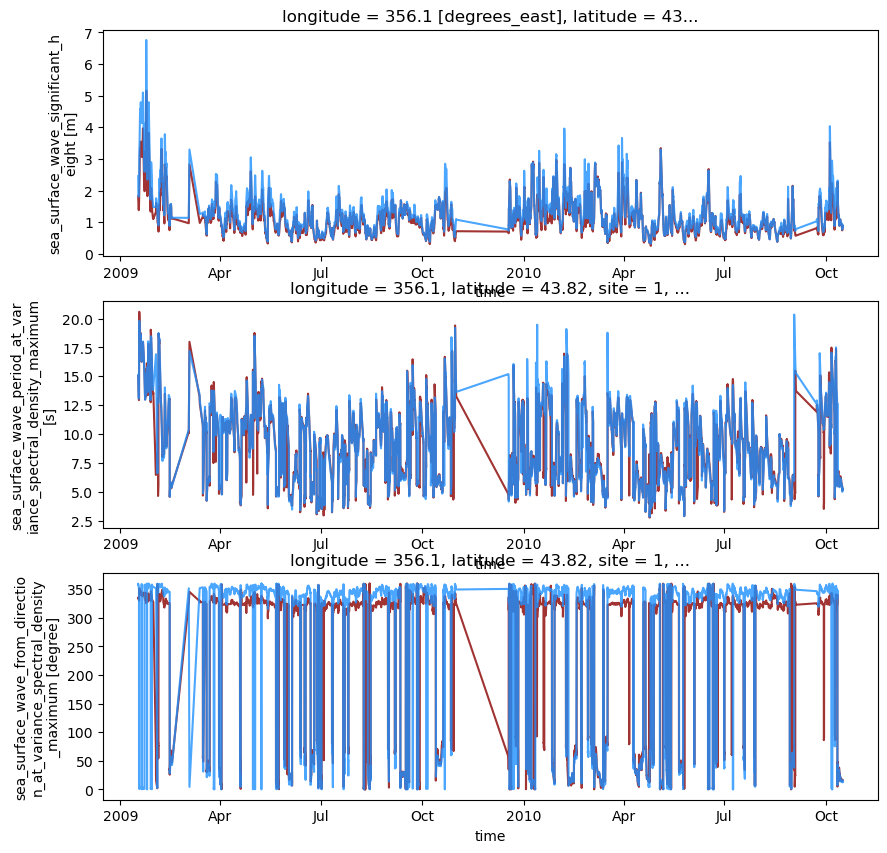

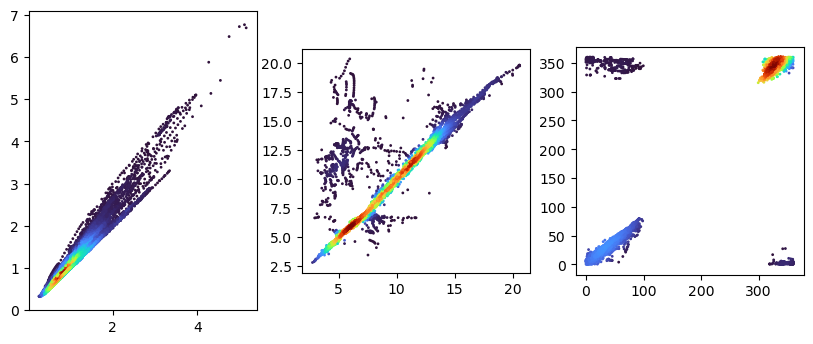

In [4]:
plot_wave_series(
    buoy_data=buoy_waves.efth.spec,
    binwaves_data=reconstructed_onshore_spectra.sel(
        site=1, time=buoy_waves.time, method="nearest"
    ).efth.spec,
)